<a href="https://colab.research.google.com/github/sarveshrocks8/Plant-Disease-Prediction-Model/blob/main/Leaf_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras import backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

import kagglehub
import os

# Step 1: Download dataset
path = kagglehub.dataset_download("emmarex/plantdisease")
print("✅ Dataset downloaded at:", path)

# Step 2: Check what's inside
print("📁 Folders in dataset:", os.listdir(path))

# Step 3: Use this path in ImageDataGenerator or model pipeline
data_dir = path + "/plantvillage"  # adjust folder name if needed


✅ Dataset downloaded at: /kaggle/input/plantdisease
📁 Folders in dataset: ['PlantVillage', 'plantvillage']


In [2]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = data_dir
width=256
height=256
depth=3

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
from os import listdir

image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Image loading completed


In [7]:
image_size = len(image_list)

In [8]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [9]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [10]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [11]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [12]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [13]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 85, 85, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 85, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 85, 85, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 85, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 42, 42, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 42, 42, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 58,102,671 (221.64 MB)

 Trainable params: 58,099,791 (221.63 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [15]:
from tensorflow.keras.optimizers import Adam

# Use 'learning_rate' instead of 'lr'
opt = Adam(learning_rate=INIT_LR)

# Compile the model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] training network...")


[INFO] training network...


In [16]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 65s 662ms/step - accuracy: 0.1704 - loss: 0.7833 - val_accuracy: 0.0694 - val_loss: 5.5782
Epoch 2/25
 1/73 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.1875 - loss: 0.3599

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1875 - loss: 0.3599 - val_accuracy: 0.0694 - val_loss: 5.6579
Epoch 3/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 473ms/step - accuracy: 0.2739 - loss: 0.2970 - val_accuracy: 0.0694 - val_loss: 1.0627
Epoch 4/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5625 - loss: 0.2190 - val_accuracy: 0.0694 - val_loss: 0.9668
Epoch 5/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 38s 452ms/step - accuracy: 0.4591 - loss: 0.2114 - val_accuracy: 0.0981 - val_loss: 0.5642
Epoch 6/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5000 - loss: 0.2037 - val_accuracy: 0.1015 - val_loss: 0.5679
Epoch 7/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 467ms/step - accuracy: 0.5774 - loss: 0.1648 - val_accuracy: 0.1387 - val_loss: 0.6369
Epoch 8/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5938 - loss: 0.1277 - val_accuracy: 0.1404 - val_loss: 0.6291
Epoch 9/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 34s 468ms/step - accuracy: 0.6191 - loss: 0.1487 - val_accuracy: 0.1235 - val_loss

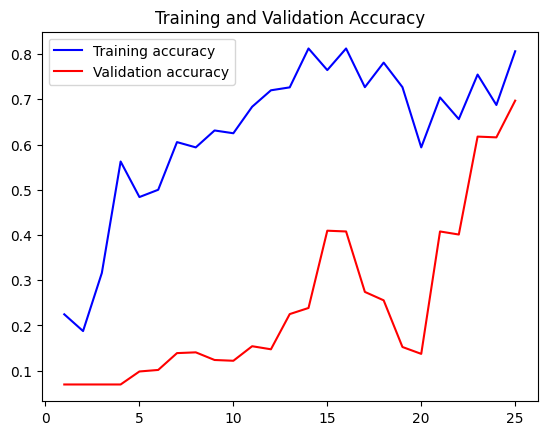

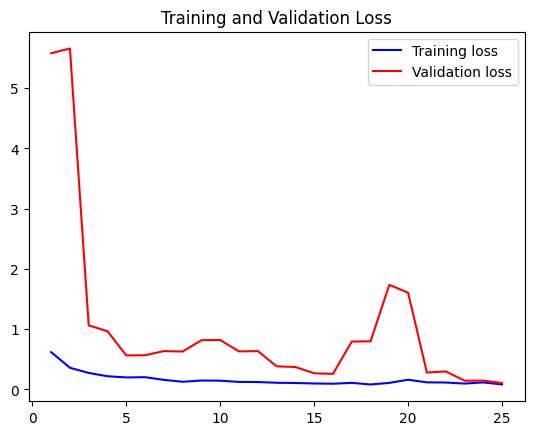

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig("accuracy_plot.png")
plt.show()

# Train and validation loss
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig("loss_plot.png")
plt.show()


In [19]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7048 - loss: 0.1054
Test Accuracy: 69.71235275268555


In [20]:
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...


In [21]:
loaded_model = pickle.load(open('cnn_model.pkl', 'rb'))

In [23]:
loaded_model = pickle.load(open('/content/cnn_model.pkl', 'rb'))

In [28]:
import os
folder_path = "/kaggle/input/plantdisease/plantvillage/PlantVillage/Potato___Early_blight"
image_files = os.listdir(folder_path)

if image_files:
    image_path = os.path.join(folder_path, image_files[0])
    im = convert_image_to_array(image_path)
    np_image_li = np.array(im, dtype=np.float16) / 255.0
    npp_image = np.expand_dims(np_image_li, axis=0)
    result = model.predict(npp_image)
    print(result)
else:
    print("No images found in the folder.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
[[8.5876836e-06 4.6334203e-09 9.9898154e-01 4.6096722e-04 6.9937848e-08
  2.0598864e-06 2.4332789e-04 2.4986625e-04 1.3095052e-05 7.4821210e-06
  2.1283500e-07 1.0729538e-05 2.3084851e-07 1.0817651e-07 2.1702661e-05]]


In [29]:
result=model.predict(npp_image)

print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[8.5876836e-06 4.6334203e-09 9.9898154e-01 4.6096722e-04 6.9937848e-08
  2.0598864e-06 2.4332789e-04 2.4986625e-04 1.3095052e-05 7.4821210e-06
  2.1283500e-07 1.0729538e-05 2.3084851e-07 1.0817651e-07 2.1702661e-05]]


In [30]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.99898154
Potato___Early_blight
